Top 5 performers based on weekly returns

In [3]:
import pandas as pd
ohlc_data = pd.read_csv('/content/EOD.csv')
def get_top_performers(ohlc_data):
    ohlc_data['Date'] = pd.to_datetime(ohlc_data['Date'],  errors ='coerce')
    ohlc_data.set_index('Date', inplace=True)
    weekly_returns = ohlc_data.groupby('Ticker')['Close'].resample('W').last().pct_change().dropna()
    top_performers = weekly_returns.groupby('Ticker').mean().nlargest(5)
    return top_performers
top_performers = get_top_performers(ohlc_data)
print(top_performers)

Ticker
BSE-500     0.034146
TCS         0.005678
BSE-200     0.003581
NSEI       -0.003818
RELIANCE   -0.015778
Name: Close, dtype: float64


Weekly top 5 performers with Stop loss as 2 times ATR on the entry price.

In [4]:
ohlc_data['High-Low'] = ohlc_data['High'] - ohlc_data['Low']
ohlc_data['High-PrevClose'] = abs(ohlc_data['High'] - ohlc_data['Close'].shift(1))
ohlc_data['Low-PrevClose'] = abs(ohlc_data['Low'] - ohlc_data['Close'].shift(1))
ohlc_data['TR'] = ohlc_data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
ohlc_data['ATR'] = ohlc_data['TR'].rolling(window=14).mean()

filtered_data = ohlc_data[ohlc_data['Ticker'].isin(top_performers.index)]

trades = []
for ticker, data in filtered_data.groupby('Ticker'):
    entry_price = data['Close'].iloc[0]
    atr = data['ATR'].iloc[-1]
    stop_loss = entry_price - (2 * atr)
    trades.append({'Ticker': ticker, 'EntryPrice': entry_price, 'StopLoss': stop_loss})

trades_df = pd.DataFrame(trades)

print(trades_df)

     Ticker    EntryPrice      StopLoss
0   BSE-200   6645.950195   6537.271624
1   BSE-500  20785.240230  20441.568631
2      NSEI  15413.299810  15162.900256
3  RELIANCE   2505.600098   2444.178641
4       TCS   3222.949951   3138.342913


Weekly performance of all the 5 stocks with stop loss as 2 times ATR on the entry price

In [5]:
ohlc_data['High-Low'] = ohlc_data['High'] - ohlc_data['Low']
ohlc_data['High-PrevClose'] = abs(ohlc_data['High'] - ohlc_data['Close'].shift(1))
ohlc_data['Low-PrevClose'] = abs(ohlc_data['Low'] - ohlc_data['Close'].shift(1))
ohlc_data['TR'] = ohlc_data[['High-Low', 'High-PrevClose', 'Low-PrevClose']].max(axis=1)
ohlc_data['ATR'] = ohlc_data['TR'].rolling(window=14).mean()
trades_df = pd.DataFrame(columns=['Ticker', 'EntryPrice', 'StopLoss'])
for week, weekly_data in ohlc_data.groupby(pd.Grouper(freq='W')):
    filtered_data = weekly_data[weekly_data['Ticker'].isin(top_performers.index)]
    trades = []
    for ticker, data in filtered_data.groupby('Ticker'):
        entry_price = data['Close'].iloc[0]
        atr = data['ATR'].iloc[-1]
        stop_loss = entry_price - (2 * atr)
        trades.append({'Ticker': ticker, 'EntryPrice': entry_price, 'StopLoss': stop_loss})
    trades_df = pd.concat([trades_df, pd.DataFrame(trades)], ignore_index=True)

print(trades_df)

       Ticker    EntryPrice      StopLoss
0     BSE-200   6645.950195   4683.253486
1     BSE-500  20998.550780  18985.950682
2        NSEI  15413.299810           NaN
3    RELIANCE   2505.600098   2320.028739
4         TCS   3222.949951   -281.428852
..        ...           ...           ...
260   BSE-200   8121.470215   8012.791644
261   BSE-500  25631.660160  25287.988561
262      NSEI  18755.449220  18505.049666
263  RELIANCE   2551.800049   2490.378592
264       TCS   3210.399902   3125.792864

[265 rows x 3 columns]


Rebalancing the stocks on weekly basis

In [6]:
def calculate_commission(trade_value, commission_rate):
    commission = trade_value * commission_rate
    return commission

def calculate_slippage(entry_price, exit_price, slippage_percent):
    slippage = (entry_price + exit_price) * slippage_percent
    return slippage
ohlcv_data = pd.read_csv('/content/Backtest of NSEI.csv')

#NSEI
entry_date = '20-06-22'
exit_date = '23-06-21'
trade_quantity = 100
commission_rate = 0.01
slippage_percent = 0.005

entry_row = ohlcv_data[ohlcv_data['Date'] == entry_date].iloc[0]
exit_row = ohlcv_data[ohlcv_data['Date'] == exit_date].iloc[0]
entry_price = entry_row['Close']
exit_price = exit_row['Close']
trade_value = (entry_price + exit_price) * trade_quantity
commission = calculate_commission(trade_value, commission_rate)
slippage = calculate_slippage(entry_price, exit_price, slippage_percent)
print("Trade Value:", trade_value)
print("Commission:", commission)
print("Slippage:", slippage)

Trade Value: 3103710.0590000004
Commission: 31037.100590000005
Slippage: 155.18550295


Volatility: 0.15513921193370425
Max Drawdown: nan
Sharpe Ratio: -0.3167718326097917
         Date   Returns  CumulativeReturns
0    22-06-20       NaN                NaN
1    23-06-20  0.015498           1.015498
2    24-06-20 -0.015825           0.999428
3    25-06-20 -0.001591           0.997837
4    26-06-20  0.009146           1.006963
..        ...       ...                ...
743  15-06-23 -0.003615           1.812408
744  16-06-23  0.007379           1.825782
745  19-06-23 -0.003748           1.818939
746  20-06-23  0.003266           1.824880
747  21-06-23  0.002134           1.828773

[748 rows x 3 columns]


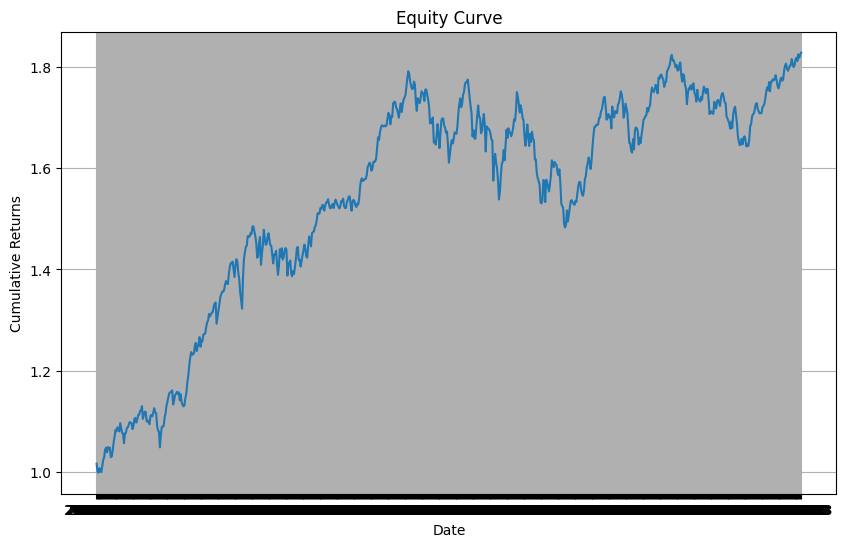

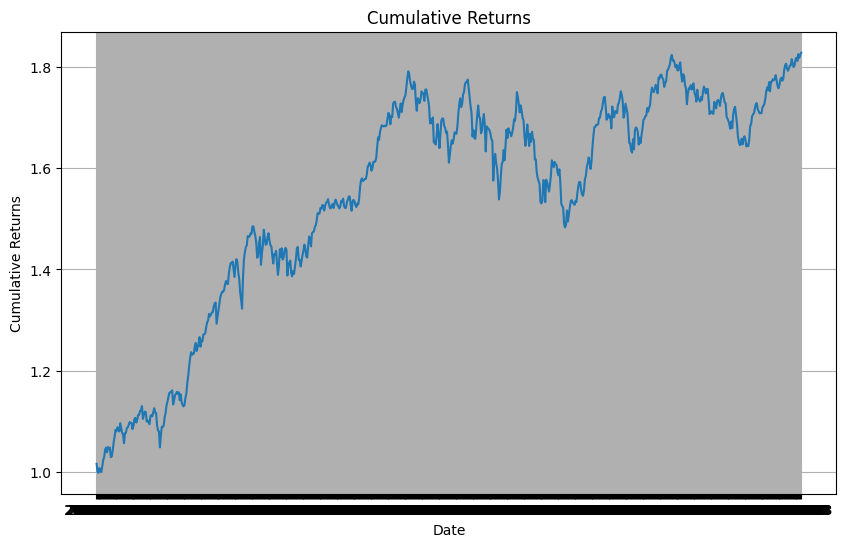

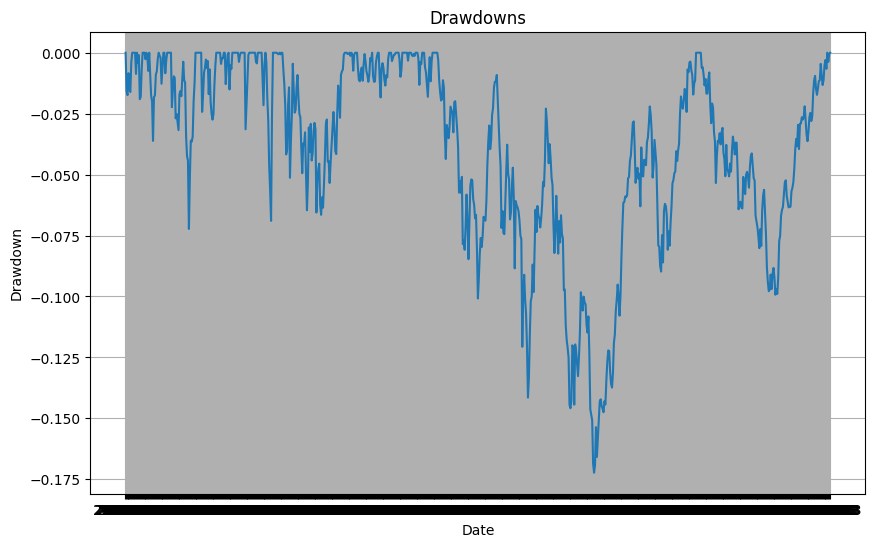

In [17]:
import numpy as np
import matplotlib.pyplot as plt
backtest_results = pd.read_csv('/content/Backtest of NSEI.csv')
backtest_results['Returns'] = backtest_results['Close'].pct_change()
volatility = np.std(backtest_results['Returns']) * np.sqrt(252)

backtest_results['CumulativeReturns'] = (1 + backtest_results['Returns']).cumprod()
backtest_results['Peak'] = backtest_results['CumulativeReturns'].cummax()
backtest_results['Drawdown'] = (backtest_results['CumulativeReturns'] / backtest_results['Peak']) - 1
backtest_results['Returns'] = backtest_results['Close'].pct_change()
max_drawdown = min(backtest_results['Drawdown'])

risk_free_rate = 0.05
sharpe_ratio = (np.mean(backtest_results['Returns']) - risk_free_rate) / volatility

print("Volatility:", volatility)
print("Max Drawdown:", max_drawdown)
print("Sharpe Ratio:", sharpe_ratio)
print(backtest_results[['Date', 'Returns', 'CumulativeReturns']])
cumulative_returns_file = '/content/CumulativeReturns.csv'
backtest_results[['Date', 'CumulativeReturns']].to_csv(cumulative_returns_file, index=False)
# Generate equity curve plot
plt.figure(figsize=(10, 6))
plt.plot(backtest_results['Date'], backtest_results['CumulativeReturns'])
plt.title('Equity Curve')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Generate cumulative returns plot
plt.figure(figsize=(10, 6))
plt.plot(backtest_results['Date'], backtest_results['CumulativeReturns'])
plt.title('Cumulative Returns')
plt.xlabel('Date')
plt.ylabel('Cumulative Returns')
plt.grid(True)
plt.show()

# Generate drawdowns plot
plt.figure(figsize=(10, 6))
plt.plot(backtest_results['Date'], backtest_results['Drawdown'])
plt.title('Drawdowns')
plt.xlabel('Date')
plt.ylabel('Drawdown')
plt.grid(True)
plt.show()

Performing backtest on 3 years data with complete analysis of the strategy using pyfolio.

In [8]:
pip install git+https://github.com/quantopian/pyfolio

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
  Cloning https://github.com/quantopian/pyfolio to /tmp/pip-req-build-um59_l4p
  Running command git clone --filter=blob:none --quiet https://github.com/quantopian/pyfolio /tmp/pip-req-build-um59_l4p
  Resolved https://github.com/quantopian/pyfolio to commit 4b901f6d73aa02ceb6d04b7d83502e5c6f2e81aa
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 52.8/52.8 kB 4.8 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 1.6/1.6 MB 56.1 MB/s eta 0:00:00
  Created wheel for pyfolio: filename=pyfolio-0.9.2+75.g4b901f6-py3-none-any.whl size=75761 sha256=7f8ae71e35f266fb05392c98ee16699486085f52ed6ceada0abc6d6919aa2b1a
  Stored in directory: /tmp/pip-ephem-wheel-cache-38kr49ka/wheels/25/2f/dd/558b6be9405213c9f6fdb1c5a062028a4da70862268f4116e6
  Created wheel for empyrical: filename=empyrical-0.5.5-py3-none-any.w

/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-06-23
End date,2023-06-21
Total months,35
,Backtest
Annual return,22.586%
Cumulative returns,82.877%
Annual volatility,15.524%
Sharpe ratio,1.39
Calmar ratio,1.31
Stability,0.71
Max drawdown,-17.23%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.23,2021-10-18,2022-06-17,2022-11-24,289
1,9.93,2022-12-01,2023-03-24,2023-06-16,142
2,7.23,2020-08-28,2020-09-24,2020-10-06,28
3,6.90,2021-01-20,2021-01-29,2021-02-02,10
4,6.65,2021-02-15,2021-04-20,2021-05-27,74


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this w

Start date,2020-06-23
End date,2023-06-21
Total months,35
,Backtest
Annual return,22.586%
Cumulative returns,82.877%
Annual volatility,15.524%
Sharpe ratio,1.39
Calmar ratio,1.31
Stability,0.71
Max drawdown,-17.23%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.23,2021-10-18,2022-06-17,2022-11-24,289
1,9.93,2022-12-01,2023-03-24,2023-06-16,142
2,7.23,2020-08-28,2020-09-24,2020-10-06,28
3,6.90,2021-01-20,2021-01-29,2021-02-02,10
4,6.65,2021-02-15,2021-04-20,2021-05-27,74


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])


Stress Events,mean,min,max
New Normal,0.09%,-4.78%,4.74%


Benchmark Returns DataFrame Index:
DatetimeIndex(['2020-06-22', '2020-06-23', '2020-06-24', '2020-06-25',
               '2020-06-26', '2020-06-29', '2020-06-30', '2020-07-01',
               '2020-07-02', '2020-07-03',
               ...
               '2023-06-08', '2023-06-09', '2023-06-12', '2023-06-13',
               '2023-06-14', '2023-06-15', '2023-06-16', '2023-06-19',
               '2023-06-20', '2023-06-21'],
              dtype='datetime64[ns]', name='Date', length=748, freq=None)


/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:724: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  stats = pd.Series()
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:648: FutureWarning: iteritems is deprecated and will be removed in a future version. Use .items instead.
  for stat, value in perf_stats[column].iteritems():


Start date,2020-06-24
End date,2023-06-21
Total months,35
,Backtest
Annual return,21.984%
Cumulative returns,80.086%
Annual volatility,15.511%
Sharpe ratio,1.36
Calmar ratio,1.28
Stability,0.71
Max drawdown,-17.23%


Worst drawdown periods,Net drawdown in %,Peak date,Valley date,Recovery date,Duration
0,17.23,2021-10-18,2022-06-17,2022-11-24,289
1,9.93,2022-12-01,2023-03-24,2023-06-16,142
2,7.23,2020-08-28,2020-09-24,2020-10-06,28
3,6.90,2021-01-20,2021-01-29,2021-02-02,10
4,6.65,2021-02-15,2021-04-20,2021-05-27,74


/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/plotting.py:805: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this warning.
  oos_cum_returns = pd.Series([])
/usr/local/lib/python3.10/dist-packages/pyfolio/timeseries.py:541: FutureWarning: The default dtype for empty Series will be 'object' instead of 'float64' in a future version. Specify a dtype explicitly to silence this w

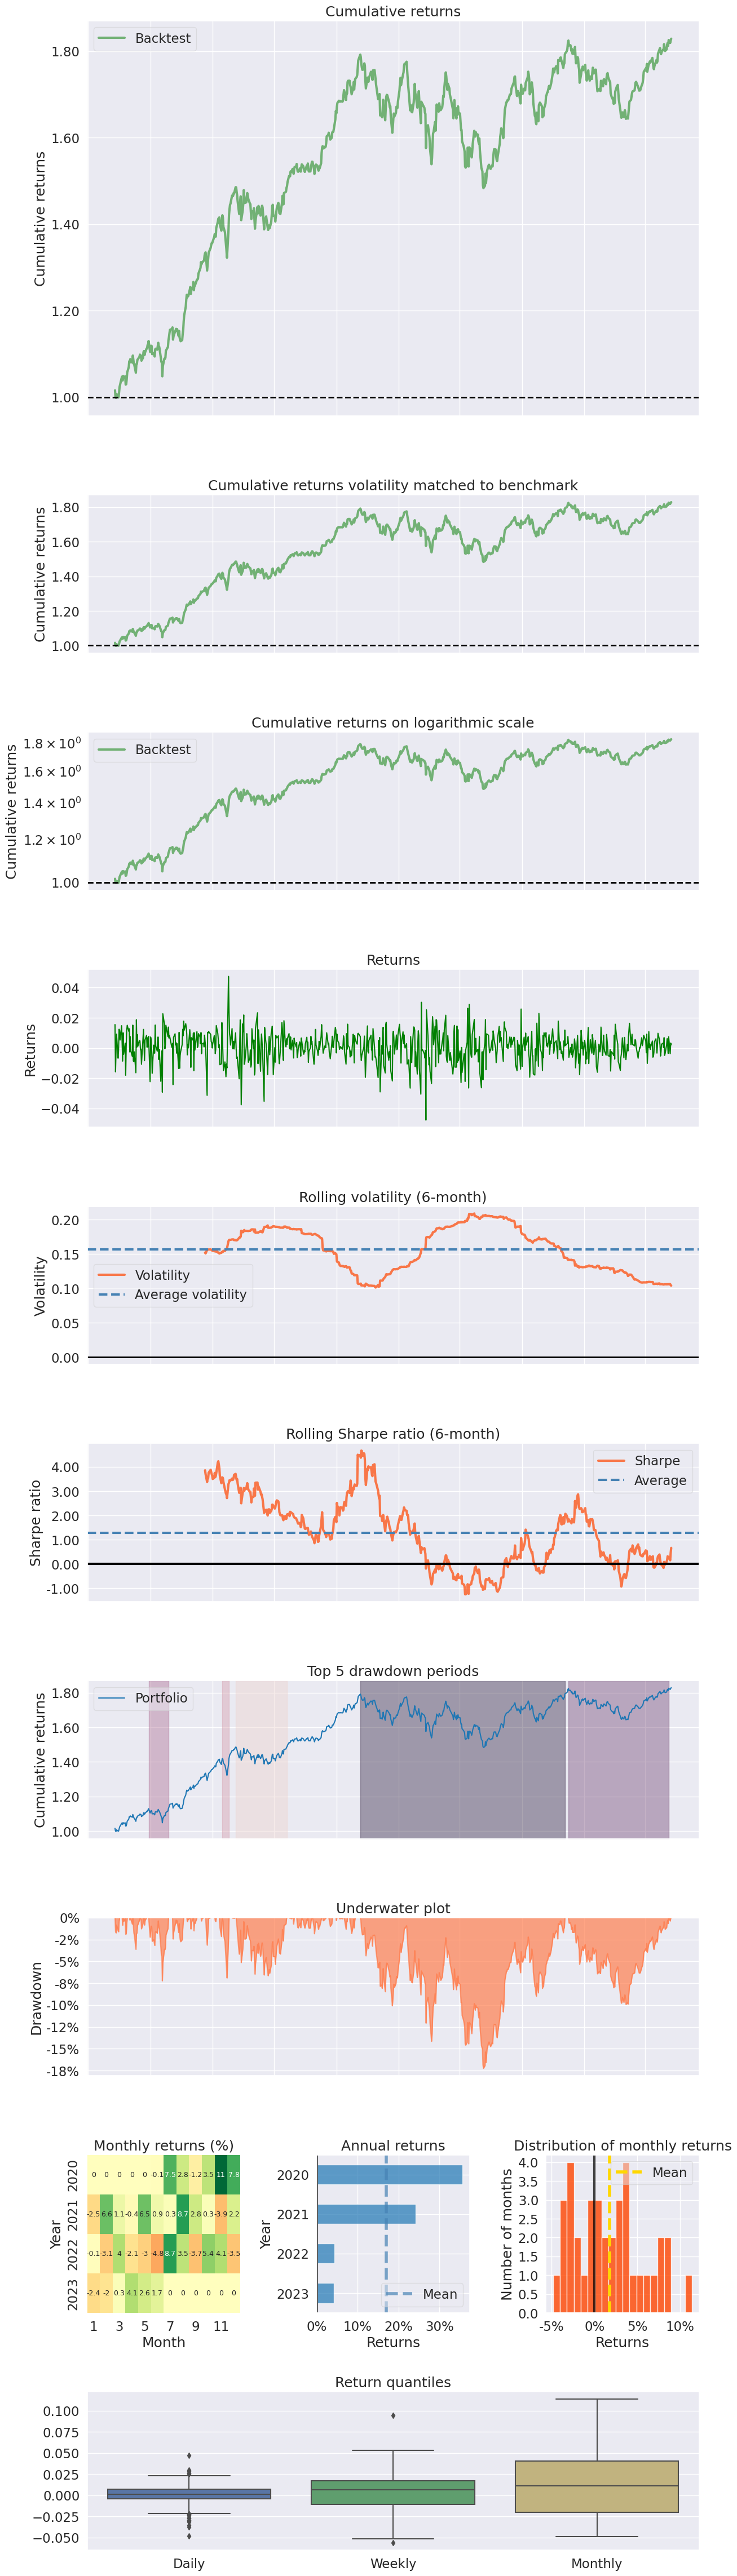

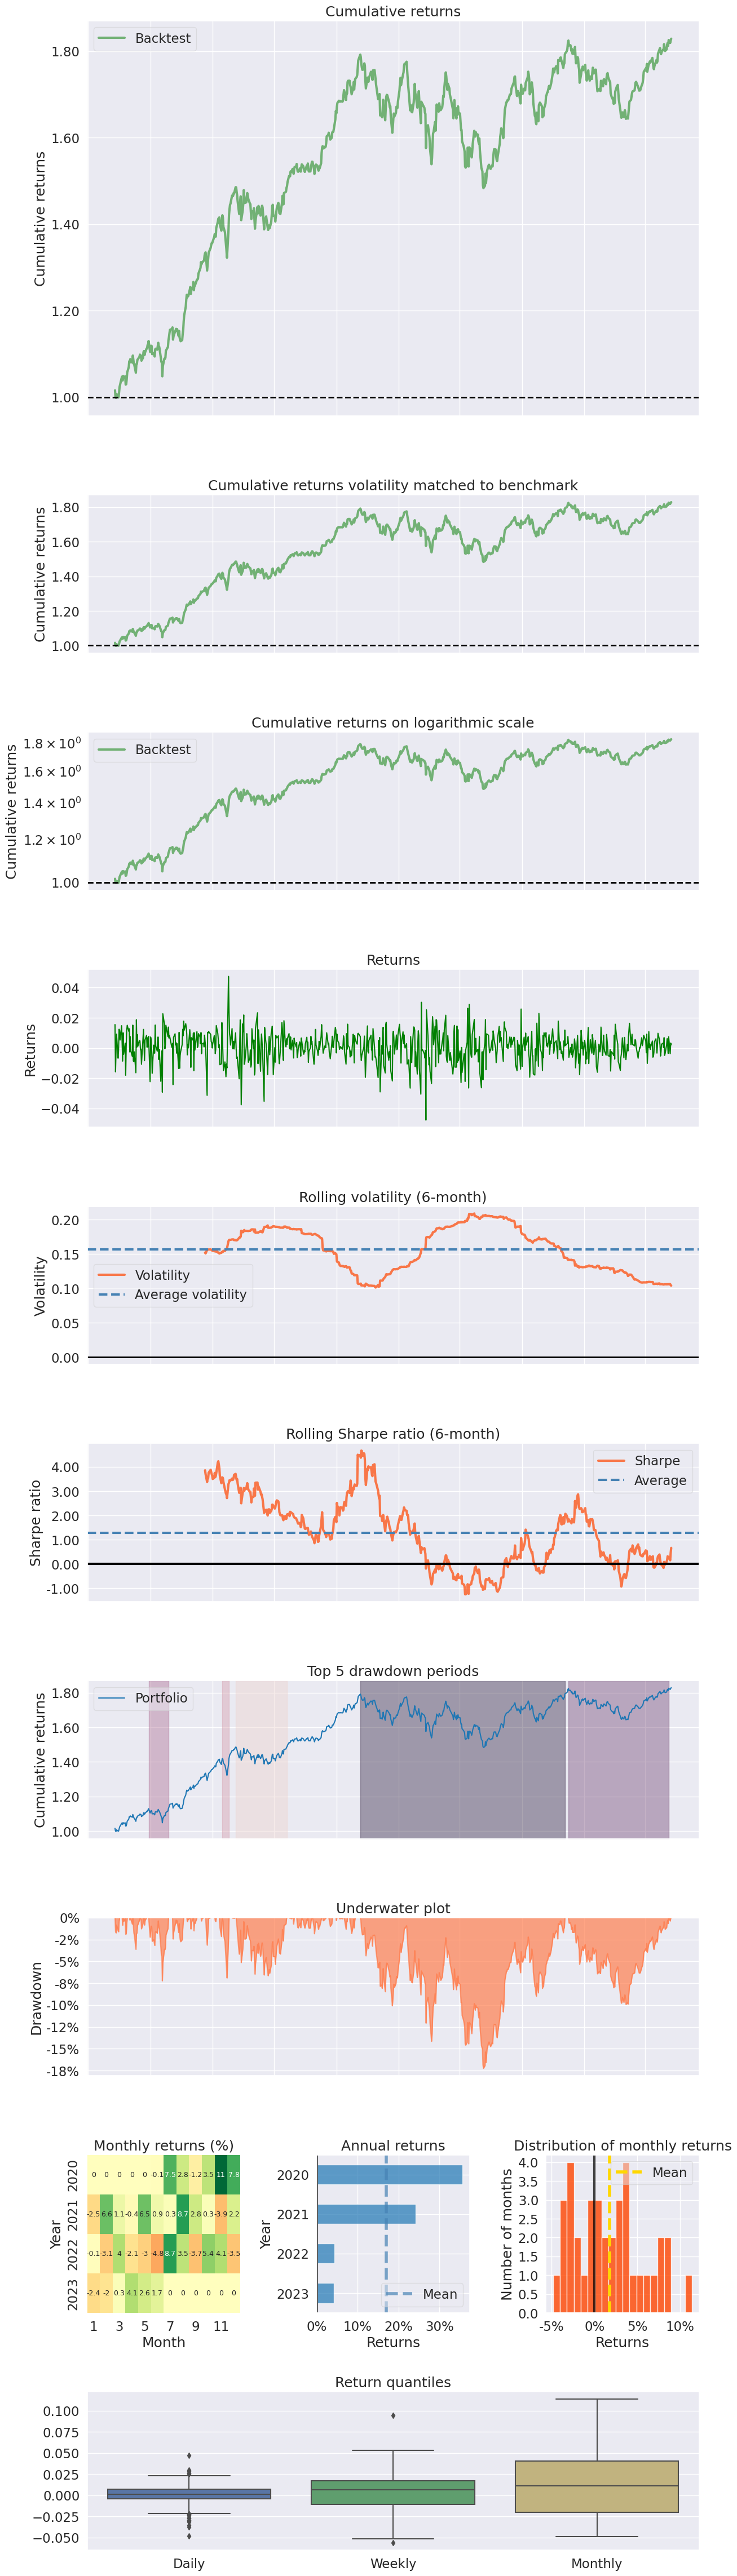

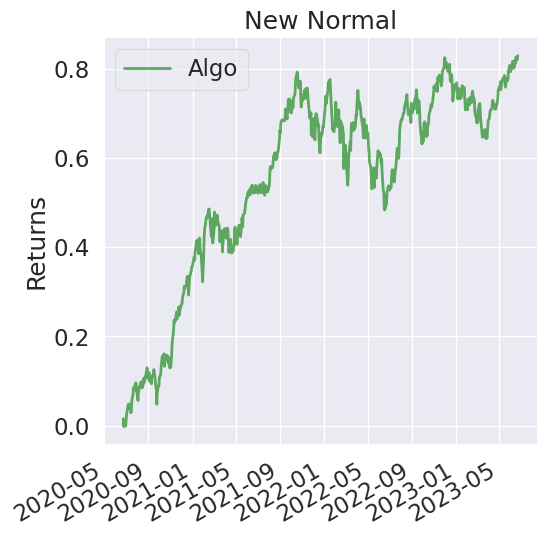

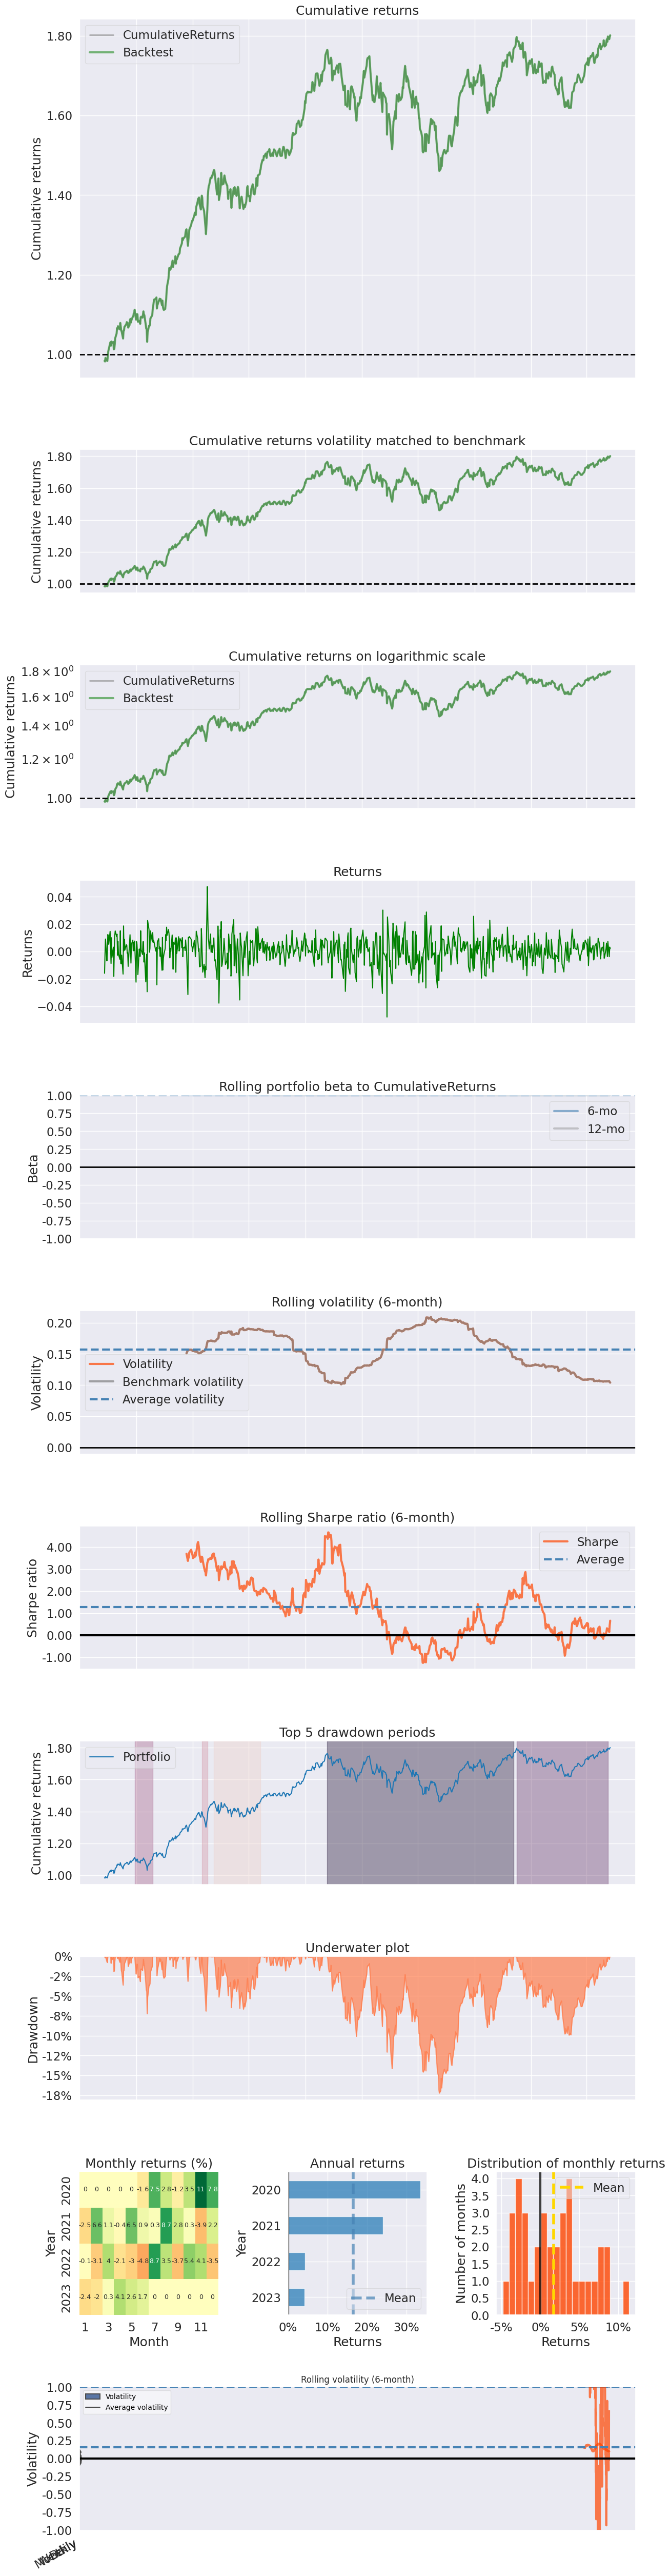

In [26]:
import pandas as pd
import pyfolio as pf
import matplotlib.pyplot as plt

# Read backtested results from a CSV file
backtest_results = pd.read_csv('/content/Backtest of NSEI.csv')

# Convert the date column to datetime
backtest_results['Date'] = pd.to_datetime(backtest_results['Date'], format='%d-%m-%y')

# Set the date column as the DataFrame index
backtest_results.set_index('Date', inplace=True)

# Calculate daily returns
backtest_results['Returns'] = backtest_results['Close'].pct_change()

# Convert returns to a Pyfolio compatible format
returns = backtest_results['Returns'].dropna()

# Convert the index to datetime if necessary
if not isinstance(returns.index, pd.DatetimeIndex):
    returns.index = pd.to_datetime(returns.index)

# Calculate various performance metrics
pf.create_returns_tear_sheet(returns)

# Analyze risk and drawdowns
pf.create_full_tear_sheet(returns)

# Benchmarking against a benchmark index
benchmark_returns = pd.read_csv('/content/CumulativeReturns.csv', index_col=0)

# Convert the date column to datetime
benchmark_returns.index = pd.to_datetime(benchmark_returns.index, format='%d-%m-%y')

# Print index values of benchmark_returns DataFrame
print("Benchmark Returns DataFrame Index:")
print(benchmark_returns.index)

benchmark_returns = benchmark_returns.pct_change().dropna()['CumulativeReturns']
pf.create_returns_tear_sheet(returns, benchmark_rets=benchmark_returns)

# Generate performance plots
pf.plotting.plot_rolling_beta(returns, benchmark_returns)
pf.plotting.plot_rolling_sharpe(returns)
pf.plotting.plot_rolling_volatility(returns)

# Display the plots
plt.show()